[Home](/)

# Prediction of Gasoline Prices using a LSTM network

By Jaime Lopez - Feb. 28, 2023

## Introduction

Predicting gasoline prices is important for several reasons, including economic planning, energy policy, consumer behavior, and international relations. Fluctuations in gasoline prices impact the global economy. Forecasts help policymakers develop and implement energy policies that promote the use of alternative fuels and reduce dependence on fossil fuels. Individual and business plan for canges in their transportation costs and adjust their behavior accordingly. Finally, the oil market is influenced by geopolitical factors that affect many countries.

Deep learning can help in predicting gasoline prices by analyzing large amounts of data and identifying patterns that are not easily visible to human analysts. However, it's important to note that the accuracy of the predictions depends on the quality of the input data and the performance of the deep learning model.

In this notebook a model is implement to predict gasoline prices using a LSTM network (Long Short-Term Memory). LSTM networks are a type of recurrent neural network that can help in predicting gasoline prices based on time series data. LSTM networks are well-suited for handling time-series data because they can capture long-term dependencies and trends in the data.

## Dataset

The dataset used in this example is a record of weekly gasoline spot prices collected by the U.S. Energy Information Administration (EIA) from Jun. 13, 2014 to Feb. 17, 2023. The dataset was obtained using the EIA API. The dataset was filtered to focus only on one location, the Port of New York City, and for conventional regular gasoline.

In the next cells, the environment is set and data is loaded into memory. A graph is shown with the gasoline prices.

In [19]:
# Loading libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [2]:
# Loading the dataset
with open('eia-petroleoum-prices-20230228.json', 'r') as finput:
    data = json.load(finput)
data = pd.DataFrame(data['response']['data'])
data.set_index('period', inplace=True)
# Filtering data for New York and regular gasoline
sample = data[(data['area-name'] == 'NEW YORK CITY') & 
    (data['product-name'] == 'Conventional Regular Gasoline')]
# Extracting prices
X = sample['value'].values
print('Number of weekly prices: ', sample.shape[0])

Number of weekly prices:  454


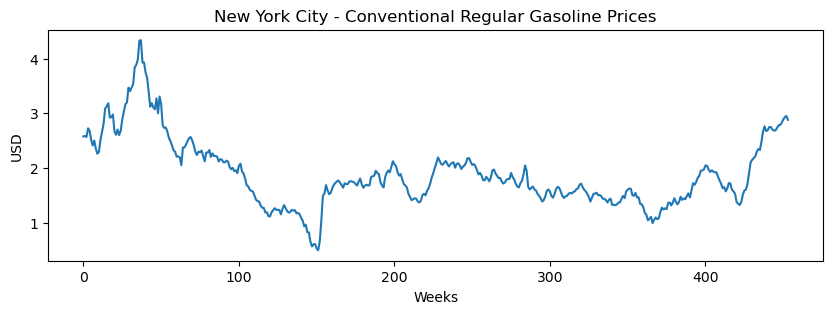

In [3]:
plt.figure(figsize=(10, 3))
plt.plot(X)
plt.ylabel('USD')
plt.xlabel('Weeks')
plt.title('New York City - Conventional Regular Gasoline Prices')
plt.show()

## Metodology

Here is how this example was developed:

* Data retrieving: The first step was to retrieve the historical gasoline prices from EIA. The dataset was provided in JSON format and was transformed to a tabular frame.

* Data preprocessing: Time windows of 35 days were used to prepare the dataset, 30 days as input and the next 5 days as prediction output. In total, 419 windows were generated, using 359 for training and 60 for testing.

* Network modeling: The LSTM network was modeled to take the feature vectors as input and output the predicted gasoline prices. The network is relatively simple, with two LSTM layers and two fully connected layers.

* Training: The LSTM network was trained using the training set and the backpropagation algorithm. The mean squared error was using as loss function the adjust the model parameters.

* Testing: Finally, the test set was used to evaluate the performance of the LSTM network on unseen data. The predicted gasoline prices were compared to the actual gasoline prices for a window of 60 days.

## Data preprocessing

* Parameters for the model development are define
* Data is scaled between 0 and 1
* Time windows are generated for training and testing
* Examples of time windows are shown

In [4]:
# How many week are covered
back_period = len(sample)
# The size of the time window
period = 35
# How many time windows for testing
test_days = 60
# How many weeks for prediction
frame = 5

In [5]:
# Data is scaled between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(np.array([X]).T)

In [6]:
# Time windows are generated
x = []
y = []
for i in range(period, len(X_scaled)):
    x.append(X_scaled[i-period:i-frame, 0])
    y.append(X_scaled[i-frame:i, 0])
x = np.array(x)
y = np.array(y)
x.shape, y.shape
print('Number of time windows: ', x.shape[0])

Number of time windows:  419


In [7]:
x_train = x[:-test_days]
y_train = y[:-test_days]
x_test = x[-test_days:]
y_test = y[-test_days:]

Plotting a few examples of time windows

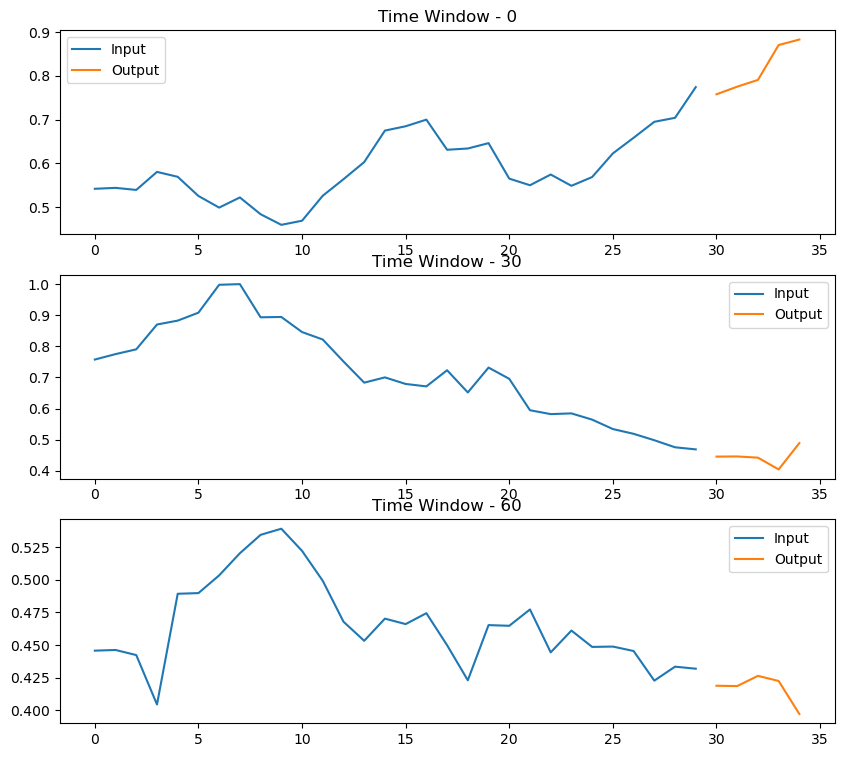

In [8]:
fig, ax = plt.subplots(nrows = 3, figsize=(10, 9))
pos = period - frame
tx = range(0, pos)
ty = range(pos, pos + frame)
offset = 30
for window in range(3):
    ax[window].plot(tx, x[window * offset], label='Input')
    ax[window].plot(ty, y[window * offset], label='Output')
    ax[window].set_title(f'Time Window - {window * offset}')
    ax[window].legend()

## Network modeling

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=16, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(units=16),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(frame)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

2023-02-28 20:01:02.874296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 20:01:02.998739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 20:01:02.998866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 20:01:02.999450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in o

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 30, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainabl

The model has two LSTM layers of 30 units each. After each LSTM layer, a dropout layer is included. At the end of the network, two fully connected layers are present. The last one has the outputs for the number the days defined for the prediction frame. Mean squared error is the loss function to updated parameters on training. The network has a total of 6 layers and 3,621 trainable parameters.

## Training

In this section the network is trained in 50 epochs using a batch size of 8 instances.

* Training
* Plotting the loss evolution during training
* Plotting the predicted timeseries using the training dataset

In [11]:
history = model.fit(x_train, y_train, epochs=50, batch_size=8, verbose=1)

Epoch 1/50


2023-02-28 20:01:07.866127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-02-28 20:01:08.097071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-28 20:01:08.114059: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7ff2e531f640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-28 20:01:08.114074: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 OEM, Compute Capability 8.6
2023-02-28 20:01:08.137480: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-28 20:01:08.141678: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_p

45/45 [==============================] - 5s 6ms/step - loss: 0.0602 - mse: 0.0602
Epoch 2/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0161 - mse: 0.0161
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0105 - mse: 0.0105
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0088 - mse: 0.0088
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0089 - mse: 0.0089
Epoch 6/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0069 - mse: 0.0069
Epoch 7/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0074 - mse: 0.0074
Epoch 8/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0065 - mse: 0.0065
Epoch 9/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0062
Epoch 10/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0064 - mse: 0.0064
Epoch 11/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0065 

Text(0.5, 0, 'Epochs')

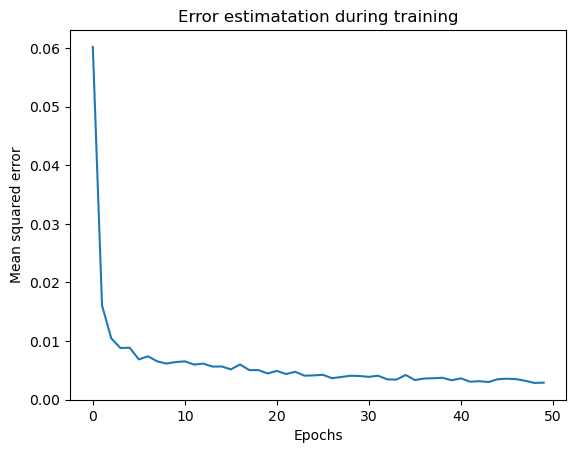

In [12]:
plt.plot(history.history['mse'])
plt.title('Error estimatation during training')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

In [13]:
y_hat = model.predict(x_train)
y_real = scaler.inverse_transform(y_train)
y_pred = scaler.inverse_transform(y_hat)

12/12 [==============================] - 0s 1ms/step


Below are the timeseries predicted using the training dataset compared against the real values. The near predictions (ex. for week 1) are more adjusted than the far predictions (week 5 forward).

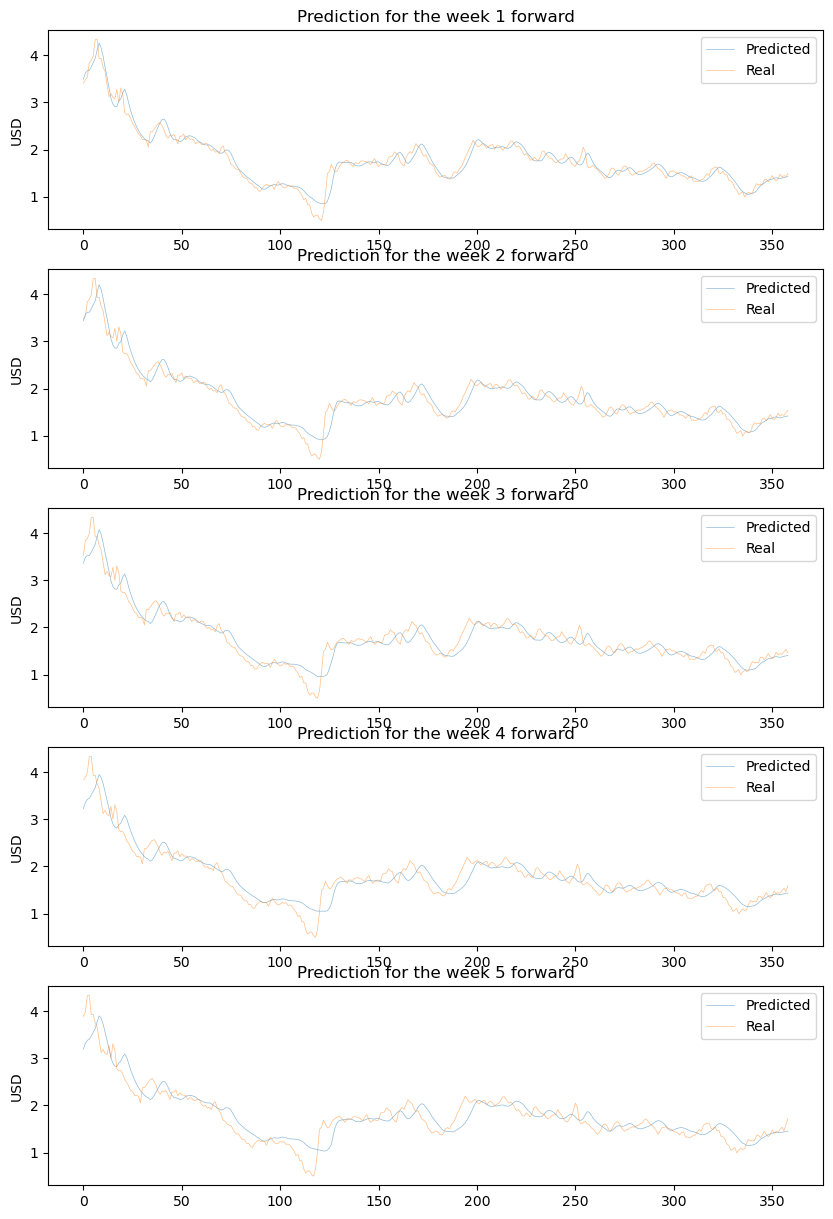

In [14]:
fig, ax = plt.subplots(nrows=frame, figsize=(10, 3 * frame))

for i in range(frame):
    _ = ax[i].plot(y_pred[:, i], linewidth=0.5, alpha=0.5, label='Predicted')
    _ = ax[i].plot(y_real[:, i], linewidth=0.5, alpha=0.5, label='Real')
    ax[i].legend()
    ax[i].set_title(f'Prediction for the week {i + 1} forward')
    ax[i].set_ylabel('USD')

## Testing

In this section the model is evaluated using the test dataset. This is unseen for the network, so is expected the error will be greater.

* Error estimation
* Plotting the predicted timeseries using the training dataset

In [15]:
est_err, _ = model.evaluate(x_test, y_test)
print('Testing MSE: ', est_err)

2/2 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041
Testing MSE:  0.004054025746881962


Notice that the training error was 0.0032, while the test error is 0.0054.

In [16]:
y_hat = model.predict(x_test)
y_real = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_hat)

2/2 [==============================] - 0s 2ms/step


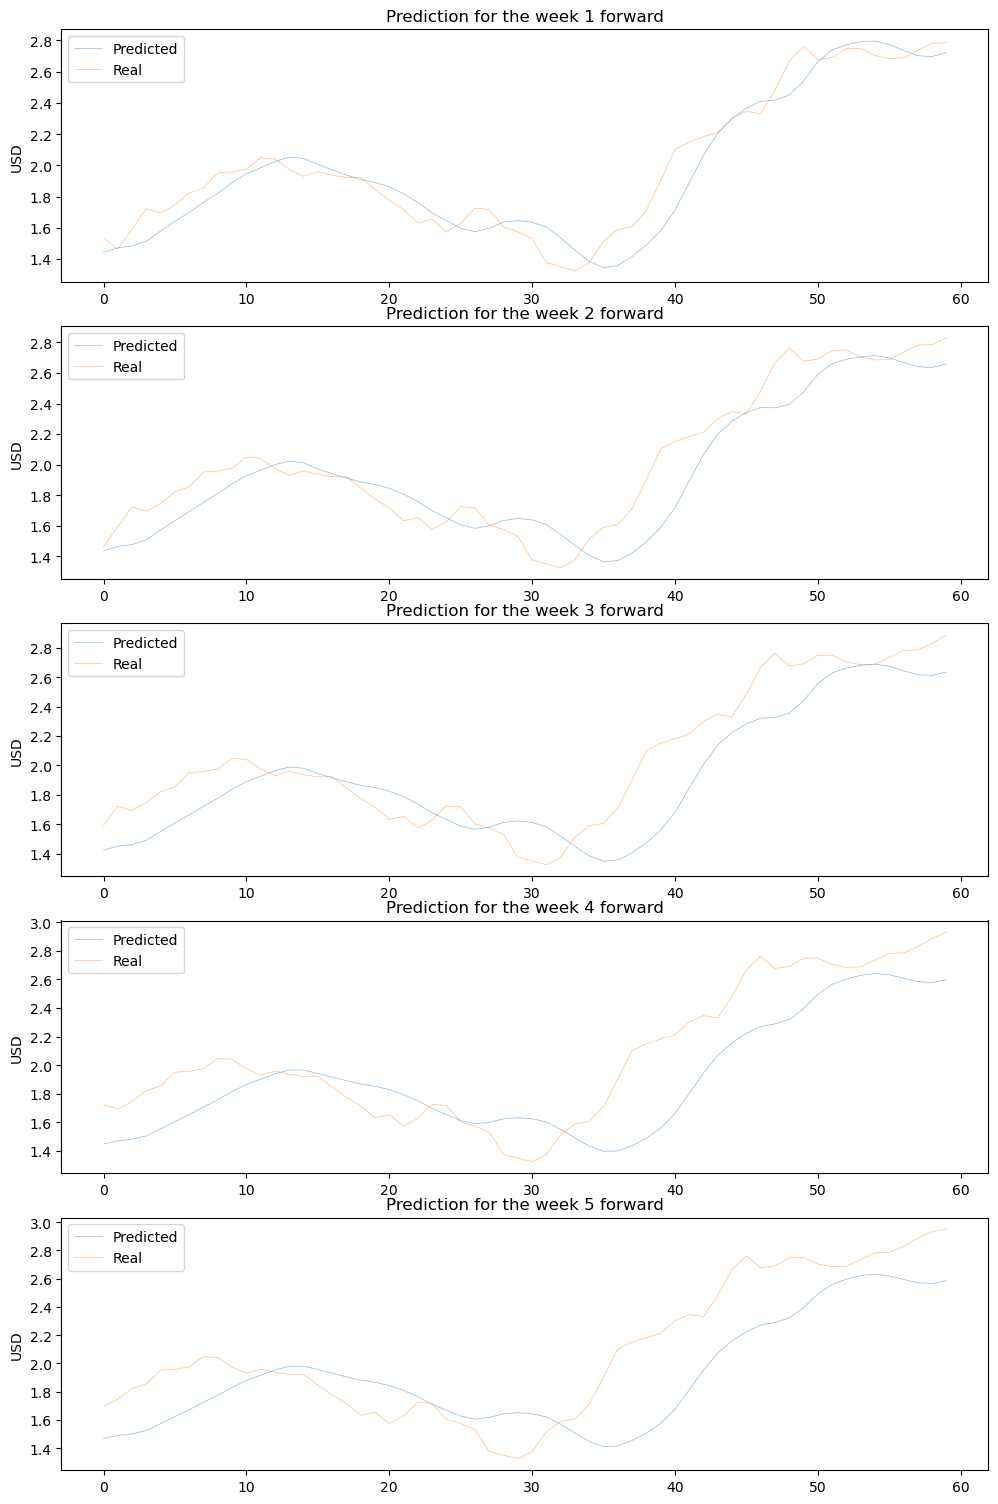

In [17]:
fig, ax = plt.subplots(nrows=frame, figsize=(10, 3 * frame))
plt.tight_layout()
for i in range(frame):
    _ = ax[i].plot(y_pred[:, i], linewidth=0.5, alpha=0.5, label='Predicted')
    _ = ax[i].plot(y_real[:, i], linewidth=0.5, alpha=0.5, label='Real')
    ax[i].legend()
    ax[i].set_title(f'Test dataset: prediction for the day {i + 1} forward')
    ax[i].legend()
    ax[i].set_title(f'Prediction for the week {i + 1} forward')
    ax[i].set_ylabel('USD')

## Discussion

* The LSTM network was able to learn meaningful patterns in the gasoline price time series data and make aceptable predictions of future prices. This suggests that the use of deep learning models like LSTMs can be effective for time series forecasting.

* The performance of the LSTM network can vary depending on the length of the time horizon being predicted. The model may be more accurate at short-term predictions (e.g., 1-2 weeks) than longer-term predictions.

* The LSTM network may benefit from additional features beyond just the gasoline price time series, such as economic indicators, weather data, or political events.

* The LSTM network was able to capture some of the seasonal and cyclical patterns in the gasoline price time series, such as regular fluctuations in price due to changes in supply and demand over the course of a year.

* The performance of the LSTM network could be improved by getting more data available and by optimizing hyperparameters such as the number of layers, the number of neurons per layer, the learning rate, and the sequence length.

## Resources

* [Notebook](./notebook.ipynb)
* [Dataset](./eia-petroleoum-prices-20230228.zip)